<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

--- 
# Part 4 : Tokenizing, Word Vectorizing & EDA

--- 

Since we are dealing with text data and classification of that text, we took steps in previous notebooks to clean and pre-process the data. For example, we removed special characters, removed markdown and html artifacts, and we now will look at possibly tokenizing, lemmatizing, and generic stop word removal on our data. We will then do further exploration of common words found in each of the subreddits as well as additional stop words we may need to remove in order to extract words that are distinguishable between the subreddits to help us classify each one. 

## Contents
- [Tokenizing & Lemmatizing](#Tokenizing-&-Lemmatizing)
- [Word Vectorizing & EDA](#Word-Vectorizing-&-EDA)
- [Summary](#Summary)

## Data Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text 
import json

In [2]:
# Read in CSV & create df

df = pd.read_csv('./data/cleaned_subreddit_data.csv')

In [3]:
df.head()

,author,num_comments,score,subreddit,timestamp,all_text
0,Erahth,12,1,MaliciousCompliance,2021-08-01 00:11:01,one more sip so this just happened my 3 5yo so...
1,MorrisonsLament,39,1,MaliciousCompliance,2021-08-01 00:12:45,you can t fire me but you can make me stop wo...
2,infiniteknights,215,1,MaliciousCompliance,2021-08-01 00:21:24,personal responsibility ok i ve been doing al...
3,SimRayB,19,1,MaliciousCompliance,2021-08-01 00:42:46,you put all of those in your mouth or you can ...
4,CSPhCT,28,1,MaliciousCompliance,2021-08-01 06:01:07,patient wants what he wants so i just need to ...


In [4]:
df.shape

(11189, 6)

In [5]:
df.isnull().sum()

author          0
num_comments    0
score           0
subreddit       0
timestamp       0
all_text        0
dtype: int64

In [6]:
df.dtypes

author          object
num_comments     int64
score            int64
subreddit       object
timestamp       object
all_text        object
dtype: object

**Notes:** The 'all_text' column is currently an object. To analyze and classify text, we will need to implement tokenizing, lemmatizing, and possibly stemming before we can vectorize the words into columns where we can count the occurence of words and their importance to classification models.

In [7]:
# Creating separate dfs for each sub

malicious = df[df['subreddit']=='MaliciousCompliance']
petty = df[df['subreddit']=='pettyrevenge']
pro = df[df['subreddit']=='ProRevenge']

In [8]:
df['subreddit'].value_counts(normalize = True)

MaliciousCompliance    0.473948
pettyrevenge           0.300295
ProRevenge             0.225757
Name: subreddit, dtype: float64

## Tokenizing & Lemmatizing

In [9]:
df['all_text'].head()

0    one more sip so this just happened my 3 5yo so...
1     you can t fire me but you can make me stop wo...
2     personal responsibility ok i ve been doing al...
3    you put all of those in your mouth or you can ...
4    patient wants what he wants so i just need to ...
Name: all_text, dtype: object

In [10]:
# Using list comprehension to loop through strings of text and create lists of words

df['tokens'] = [word_tokenize(str(text)) for text in df['all_text']]

In [11]:
df['tokens'].head()

0    [one, more, sip, so, this, just, happened, my,...
1    [you, can, t, fire, me, but, you, can, make, m...
2    [personal, responsibility, ok, i, ve, been, do...
3    [you, put, all, of, those, in, your, mouth, or...
4    [patient, wants, what, he, wants, so, i, just,...
Name: tokens, dtype: object

In [12]:
# Instantiate Lemmatizer

lemmatizer = WordNetLemmatizer()

In [13]:
# Lemmatizing tokens- returning shortened base forms of words and join the words back into a list of strings

df['tokens_lem']  = [' '.join([lemmatizer.lemmatize(word) for word in text]) for text in df['tokens']]


In [14]:
# Checking list - COMMENTING OUT for space
#list(zip(tokens, tokens_lem))
#[(tokens[i], tokens_lem[i]) for i in range(len(tokens)) if tokens[i] != tokens_lem[i]]

In [15]:
df['tokens_lem'].head()

0    one more sip so this just happened my 3 5yo so...
1    you can t fire me but you can make me stop wor...
2    personal responsibility ok i ve been doing all...
3    you put all of those in your mouth or you can ...
4    patient want what he want so i just need to sh...
Name: tokens_lem, dtype: object

## Word Vectorizing & EDA

In [16]:
# Vectorize
X = df['all_text']

In [17]:
# Baseline
df['subreddit'].value_counts(normalize=True)

MaliciousCompliance    0.473948
pettyrevenge           0.300295
ProRevenge             0.225757
Name: subreddit, dtype: float64

In [18]:
# Instantiate a CountVectorizer & remove generic stop words
cvec = CountVectorizer(max_features = 5000,
                       min_df=2,
                       stop_words = 'english',
                       ngram_range = (1,2)
                      )

In [19]:
# Fit & transform the vectorizer
vec_df= pd.DataFrame(cvec.fit_transform(X).todense(), columns=cvec.get_feature_names())

In [20]:
# Checking list of words to see if i need to do any more cleaning - commenting out for space
#cvec.get_feature_names()

### Most Common Words in All Text from 3 Subreddits Combined

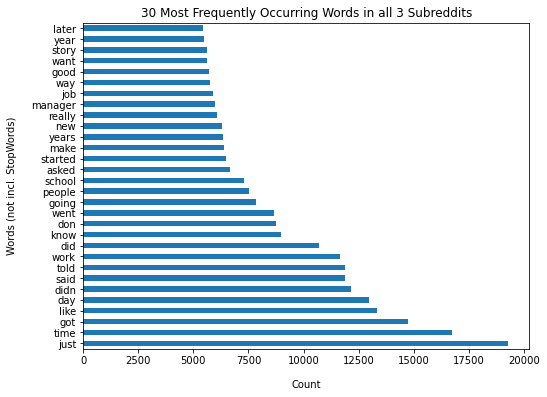

In [21]:
vec_df.sum().sort_values(ascending = False).head(30).plot(kind='barh', figsize=(8, 6))
plt.xlabel("Count", labelpad=14)
plt.ylabel("Words (not incl. StopWords)", labelpad=14)
plt.title("30 Most Frequently Occurring Words in all 3 Subreddits");

### Most Common Words for Each Subreddit

In [22]:
# Vectorizing for each sub
X1 = malicious['all_text']
X2 = petty['all_text']
X3 = pro['all_text']

vec_mal= pd.DataFrame(cvec.fit_transform(X1).todense(), columns=cvec.get_feature_names())
vec_petty= pd.DataFrame(cvec.fit_transform(X2).todense(), columns=cvec.get_feature_names())
vec_pro= pd.DataFrame(cvec.fit_transform(X3).todense(), columns=cvec.get_feature_names())

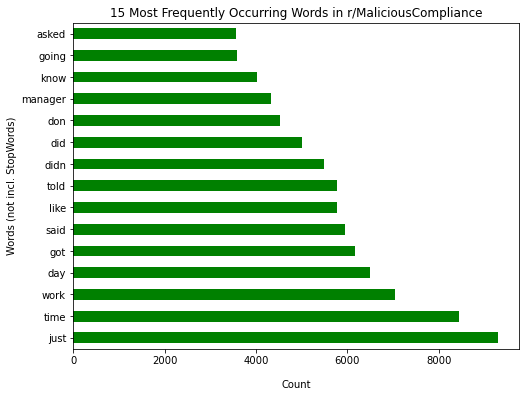

In [23]:
vec_mal.sum().sort_values(ascending = False).head(15).plot(kind='barh', figsize=(8, 6), color = 'green')
plt.xlabel("Count", labelpad=14)
plt.ylabel("Words (not incl. StopWords)")
plt.title("15 Most Frequently Occurring Words in r/MaliciousCompliance");

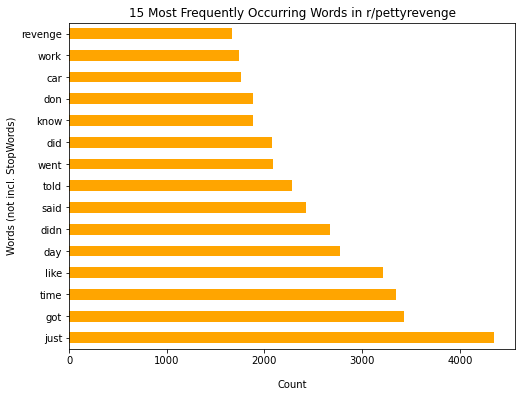

In [24]:
vec_petty.sum().sort_values(ascending = False).head(15).plot(kind='barh', figsize=(8, 6), color = 'orange')
plt.xlabel("Count", labelpad=14)
plt.ylabel("Words (not incl. StopWords)")
plt.title("15 Most Frequently Occurring Words in r/pettyrevenge");

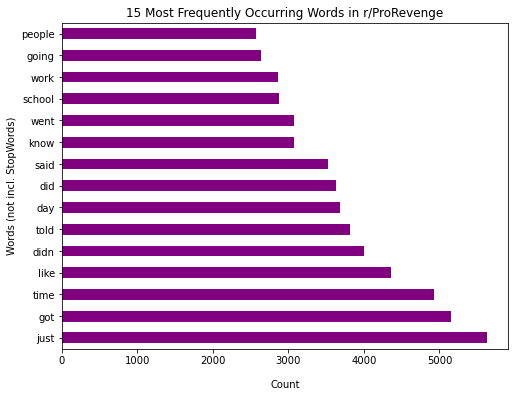

In [25]:
vec_pro.sum().sort_values(ascending = False).head(15).plot(kind='barh', figsize=(8, 6), color = 'purple')
plt.xlabel("Count", labelpad=14)
plt.ylabel("Words (not incl. StopWords)")
plt.title("15 Most Frequently Occurring Words in r/ProRevenge");

### Removing Additional Stopwords
There's a lot of overlap in word frequency between the 3 subreddits. This was an iterative process to keep adding to this list of commone words that the 3 subreddits shared. I really focused on removing any overlap between r/MaliciousCompliance from the other subreddits. /pettyrevenge and /ProRevenge were allowed to remain with common words since the goal of this project is to differentiate passive from active revenge and those 2 subreddits fall in the active revenge category. 

In [26]:
# Remove more stop words

my_stopwords = ['none','\n', 'www', 'reddit', 'comment', 'http', '00', '000','10','100','11','12','15','16',
            '18','20','25','30','40','45','50','op', 'just', 'got', 'time', 'like', 'did', 'didn', 'told', 'day', 
            'know', 'said','work', 'way', 'school', 'went', 'goin', 'don', 'going', 'people', 'started', 'asked',
            'make', 'years', 'new', 'really', 'good', 'year', 'revenge', 'petty', 'pany', 'll','wasn', 'came', 
            'later', 'story', 'let', 'say', 'job', 'right', 'home', 'left', 'tell', 'things', 'took', 'dad', 've', 
           'happened', 'getting', 'little', 'want', 'sure', 'pliance', 'minutes', 'wanted', 'class', 'called', 'mom',
               'phone', 'store', 'doing', 'away', 'ago', 'think', 'malicious', 'room', 'lot', 'guy', 'pay', 'decided',
               'thing', 'end', 'knew', 'look', 'long', 'week', 'old', 'night', 'point', 'manager', 'use', 'months',
               'car', 'says', 'days', 'teacher', 'couldn', 'thought', 'person', 'amp', 'big', 'leave', 'place', 
                'money', 'pretty', 'house', 'weeks', 'es', 'having', 'help', 'tried', 'used', 'working', 'bit',
               'friend', 'gave', 'food', 'trying', 'office', 'start', 'face', 'karen', 'small', 'door', 'head', 
                'hours', 'need', 'saying', 'best', 'boss', 'couple', 'bad', 'stuff', 'times', 'looked', 'ask', 'kids',
               'month', 'line', 'actually', 'high', 'worked', 'doesn', 'gets', 'needed', 'better', 'half', 'finally',
               'sent', 'stop', 'wouldn', 'gt', 'ply']

more_stop_words = text.ENGLISH_STOP_WORDS.union(my_stopwords)

In [27]:
len(my_stopwords)

163

## More Word Vectorizing & EDA

In [28]:
# Instantiate another CountVectorizer & remove additional stop words

cvec = CountVectorizer(max_features = 5000,
                       min_df=2,
                       max_df = 0.8,
                       stop_words = more_stop_words,
                       ngram_range = (1,2)
                      )

In [29]:
# Fit & transform the vectorizer

vec_df= pd.DataFrame(cvec.fit_transform(X).todense(), columns=cvec.get_feature_names())

In [30]:
# Vectorizing for each sub
X1 = malicious['all_text']
X2 = petty['all_text']
X3 = pro['all_text']

vec_mal= pd.DataFrame(cvec.fit_transform(X1).todense(), columns=cvec.get_feature_names())
vec_petty= pd.DataFrame(cvec.fit_transform(X2).todense(), columns=cvec.get_feature_names())
vec_pro= pd.DataFrame(cvec.fit_transform(X3).todense(), columns=cvec.get_feature_names())

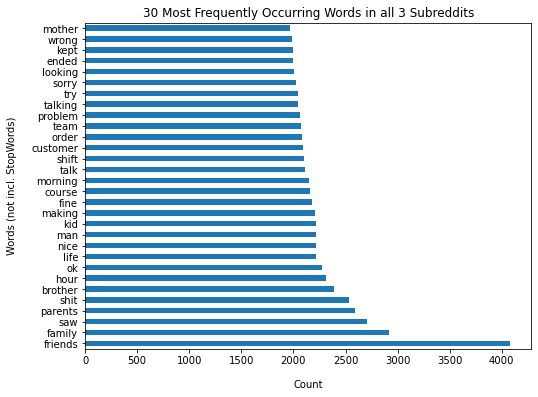

In [31]:
vec_df.sum().sort_values(ascending = False).head(30).plot(kind='barh', figsize=(8, 6))
plt.xlabel("Count", labelpad=14)
plt.ylabel("Words (not incl. StopWords)", labelpad=14)
plt.title("30 Most Frequently Occurring Words in all 3 Subreddits");

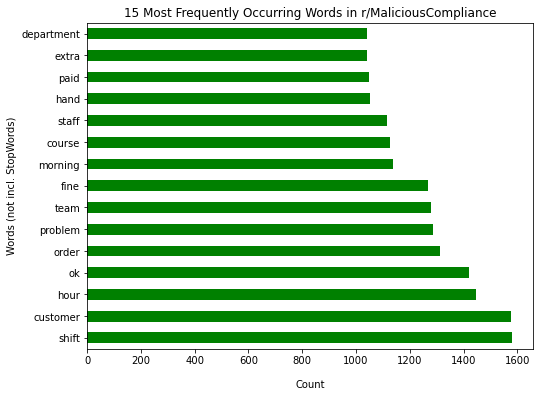

In [32]:
vec_mal.sum().sort_values(ascending = False).head(15).plot(kind='barh', figsize=(8, 6), color = 'green')
plt.xlabel("Count", labelpad=14)
plt.ylabel("Words (not incl. StopWords)")
plt.title("15 Most Frequently Occurring Words in r/MaliciousCompliance");

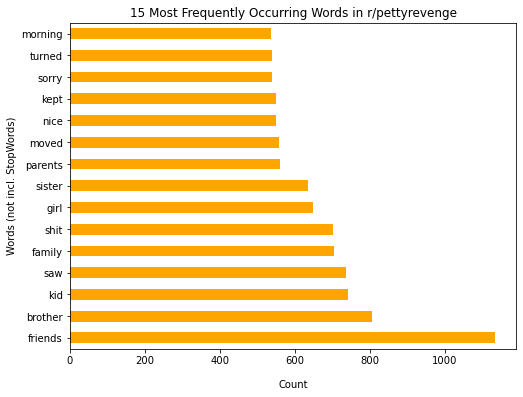

In [33]:
vec_petty.sum().sort_values(ascending = False).head(15).plot(kind='barh', figsize=(8, 6), color = 'orange')
plt.xlabel("Count", labelpad=14)
plt.ylabel("Words (not incl. StopWords)")
plt.title("15 Most Frequently Occurring Words in r/pettyrevenge");

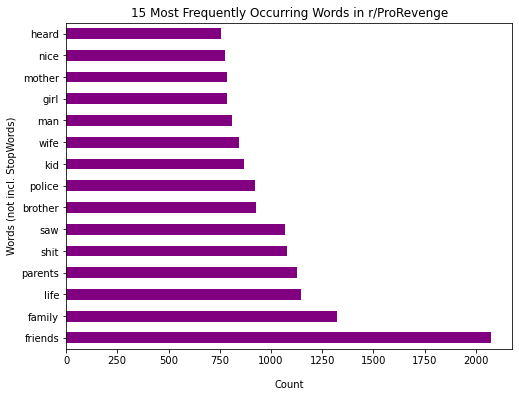

In [34]:
vec_pro.sum().sort_values(ascending = False).head(15).plot(kind='barh', figsize=(8, 6), color = 'purple')
plt.xlabel("Count", labelpad=14)
plt.ylabel("Words (not incl. StopWords)")
plt.title("15 Most Frequently Occurring Words in r/ProRevenge");

In [35]:
#REFERENCE: Gwen's repo
all_common = vec_df.mean().sort_values(ascending=False)[0:150]

mal_words = vec_mal.mean().sort_values(ascending=False)[0:150]

petty_words = vec_petty.mean().sort_values(ascending=False)[0:150]

pro_words = vec_pro.mean().sort_values(ascending=False)[0:150]

/Users/emilysiegel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/emilysiegel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/emilysiegel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

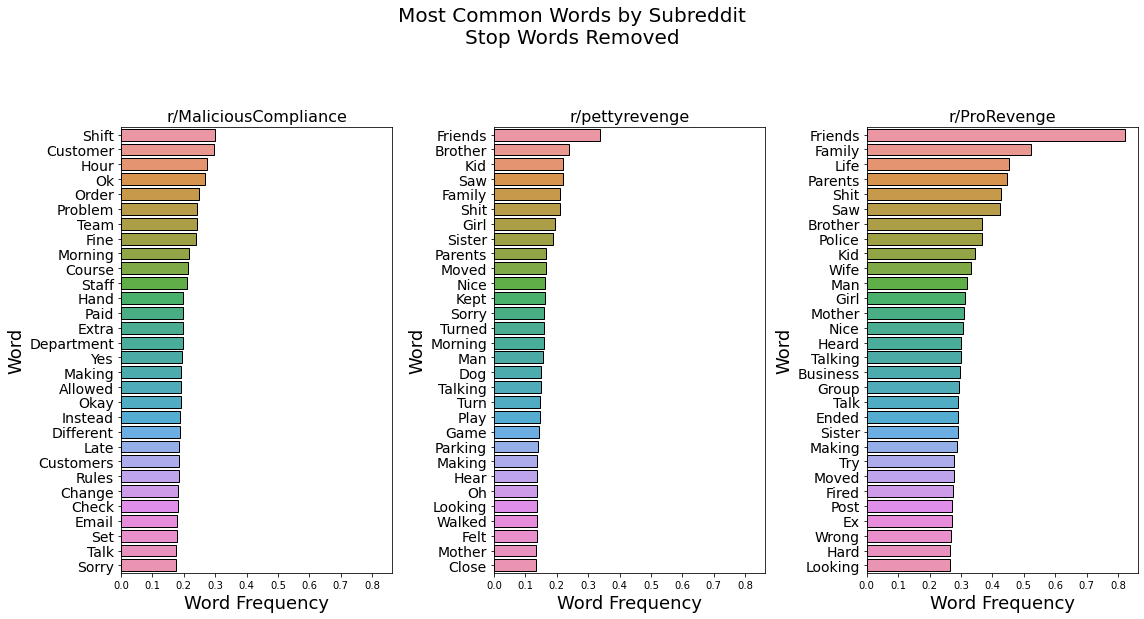

In [36]:
#REFERENCE: Gwen's repo
tables = [mal_words,petty_words, pro_words]
titles = ['r/MaliciousCompliance','r/pettyrevenge','r/ProRevenge']

fig, ax = plt.subplots(1,3, sharex=True, figsize=(16,8))
axs = ax.ravel()
fig.suptitle('Most Common Words by Subreddit\nStop Words Removed', fontsize=20, y=1.07)
for i, ax in enumerate(axs):
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_title(titles[i], fontsize=16)
    ax.set_xlabel('Word Frequency', fontsize=18)
    ax.set_ylabel('Word', fontsize=18)
    sns.barplot(tables[i][0:30],tables[i].index.str.title()[0:30], orient='h',ax=ax, ec='k', linewidth=1)
fig.tight_layout()

In [37]:
mal_freq = vec_mal.mean() - (vec_petty.mean() + vec_pro.mean())
words_mal = mal_freq.dropna().sort_values(ascending=False)

other_freq = (vec_petty.mean() + vec_pro.mean()) - vec_mal.mean()
words_other = other_freq.dropna().sort_values(ascending=False)

/Users/emilysiegel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/emilysiegel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


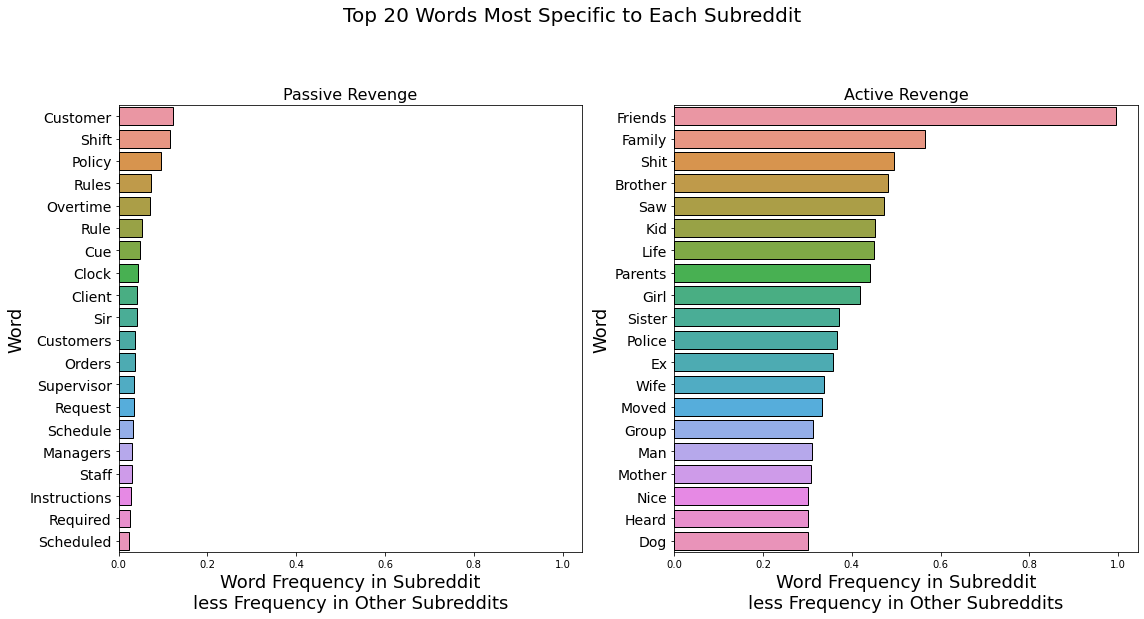

In [38]:
tables = [words_mal,words_other]
titles = ['Passive Revenge','Active Revenge']

fig, ax = plt.subplots(1,2, sharex=True, figsize=(16,8))
axs = ax.ravel()
fig.suptitle('Top 20 Words Most Specific to Each Subreddit', fontsize=20, y=1.07)
for i, ax in enumerate(axs):
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_title(titles[i], fontsize=16)
    ax.set_xlabel('Word Frequency in Subreddit\nless Frequency in Other Subreddits', fontsize=18)
    ax.set_ylabel('Word', fontsize=18)
    sns.barplot(tables[i][0:20],tables[i].index.str.title()[0:20], orient='h',ax=ax, ec='k', linewidth=1)
fig.tight_layout()

In [44]:
# REFERENCE: https://stackoverflow.com/questions/7100125/storing-python-dictionaries
# Save our stop words as a list then dict then json file

stopwords_dict = {'words': list(more_stop_words)}

In [46]:
json.dump(stopwords_dict, open('./data/more_stopwords.json', 'w'))
stopwords_dict = json.load(open('./data/more_stopwords.json'))

## Summary

163 custom stop words were removed and an analysis of the most common words occurring in each subreddit was completed. 